# Ames: Engineering, Modeling


### Executive Summary

 - [Initial Setup](#Initial-Setup)
 - [Feature Engineering](#Feature-and-Target-Engineering)
 - [Split and Transform](Train-Test-Split)
 - [Modeling](#Modeling)

****
### Initial Setup

#### Intro

In our previous notebook, we did the following:

 - Initial Exploration of the Ames housing data
 - Cleaned data, including ordinal encoding
 - Handled NaN data
 - Incorporated dummy features
 
We are now ready to read back in our file. Our focus here will be on further EDA, model construction, and submission. Let's start by getting our libraries in place, and reading in our file.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet,  ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import r2_score
%matplotlib inline

#### Take out in-family Sales

There are a few outliers that appear to be in home family sales. Let's remove these. before we do anything -- these were significant outliers in our residual plotting.

In [3]:
#Read in our cleaned data file
houses = pd.read_csv('./datasets/houses_clean.csv')

In [4]:
houses.drop([154], inplace=True)

In [5]:
houses.drop([1885], inplace=True)

#### Separate Training and Test Sets...Again

Recall that we had merged together our test and train data sets to apply the same cleaning and null imputation techniques. While there are other approaches, this allowed us to maintain the same level of features across our data sets while also accounting for all NaN edge cases. Now, because we are going to finally fit our Linear Regression model to our data set, we'll work to split these back out. The traditional notation for our features and target data will be **X**, and **y**.

In [6]:
#Grab our SalePrice data
y = houses['SalePrice']
y_train_data = y[:2048]

#Set aside submission IDs so we can use these later
submission_ids = houses.iloc[2048:,:]
submission_ids = submission_ids['Id']

#Grab our features and drop all non-numeric features
X = houses.drop(columns=['SalePrice'])
X = X.select_dtypes(exclude='object')

#Separate the test data set from the training data set again
X_train_alt = X.iloc[:2048,:]
X_test_alt  = X.iloc[2048:,:]

In [7]:
y_train_data.sort_values(ascending=True)

1628     12789
183      13100
1309     34900
1292     35000
1518     35311
         ...  
151     556581
1796    582933
1692    584500
1964    591587
1671    611657
Name: SalePrice, Length: 2048, dtype: int64

In [8]:
y_train_data.shape, X_train_alt.shape, X_test_alt.shape

((2048,), (2048, 132), (880, 132))

****
### Feature and Target Engineering

This section has been widdled down significantly after experimentation. We spent a significant amount of time here testing both **polynomial feature inclusion** and **number of total features**. The exploration of polynomial features here makes sense -- interaction terms can often produce features that, when combined, are more strongly correlated with our target and can thereby produce a stronger model. 

There are some cons here, however. First, polynomial feature creation can result in a high number of features -- in our case, we saw upward of **5,000-15,000** features after fitting our PolynomialFeatures() object, depending on the base number of features evaluated. Without trimming these down this can result in dramatic overfitting of our model. In addition to this, polynomial features can produce a lot of **multicollinearity** -- situations in which features are highly correlated with one another. This can result in a model that is highly sensitive to change (see below link for more information).

In terms of the number of total features to include, this was also a lever that we pulled in several directions -- from including a high volume of polynomial features, to none at all and looking strictly at non-polynomial features. After some experimentation we felt that there was a sweet spot in terms of R2 performance on both our test and train data sets. 

Our final approach was to remove low-correlation features from our initial dataset, and include several polynomial features which demonstrated the highest correlation with SalePrice -- most notably **Overall Qual * Total Area**, and **Overall Qual^2**. The reduction of polynomials to these two terms resulted in a simpler model that boosted R2 scores on unseen data.


 - *Source* : https://blog.minitab.com/blog/adventures-in-statistics-2/what-are-the-effects-of-multicollinearity-and-when-can-i-ignore-them

In [60]:
#Generates the full polynomial feature table.  
poly = PolynomialFeatures(include_bias=False)
X_poly_train_alt = poly.fit_transform(X_train_alt)
X_poly_train_alt.shape

X_poly = pd.DataFrame(X_poly_train_alt,columns=poly.get_feature_names(X_train_alt.columns))

#Generates list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

In [10]:
#Widdle down the number of features in our data set. 
keep_these_features = list(abs(X_train_alt.corrwith(y)).sort_values(ascending=False)[:-40].index)
X_train_alt = X_train_alt[keep_these_features]
X_test_alt = X_test_alt[keep_these_features]

In [11]:
#Based on manual testing we landed on these two options. These had also demonstrated curved relationships
X_train_alt['Overall Qual Total Area'] = X_train_alt['Overall Qual'] * X_train_alt['Total Area']
X_train_alt['Overall Qual^2'] = X_train_alt['Overall Qual'] * X_train_alt['Overall Qual']

X_test_alt['Overall Qual Total Area'] = X_test_alt['Overall Qual'] * X_test_alt['Total Area']
X_test_alt['Overall Qual^2'] = X_test_alt['Overall Qual'] * X_test_alt['Total Area']

Let's take a look at our feature correlations before moving any further.

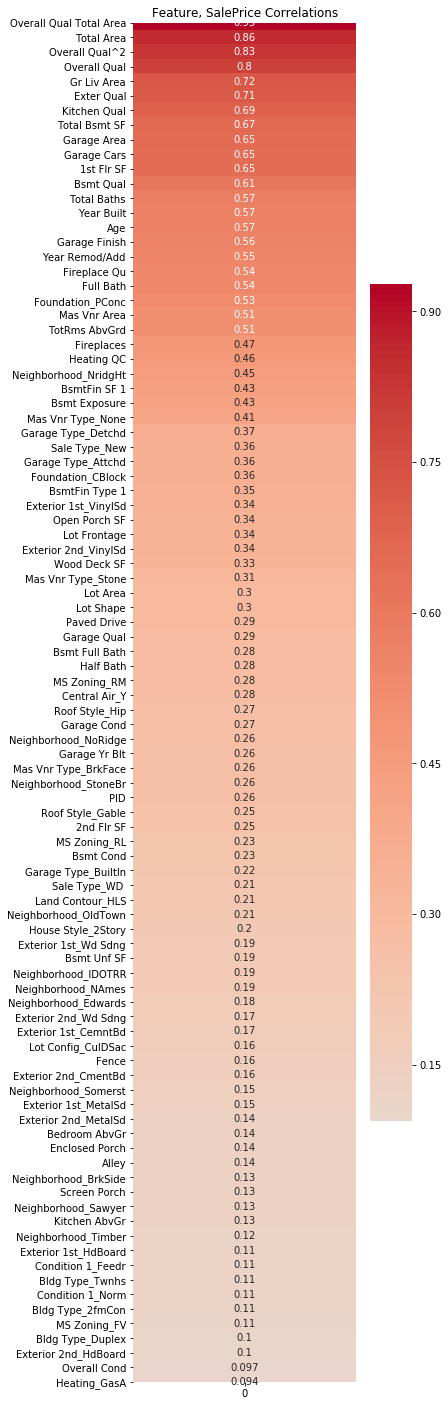

In [12]:
#Generates list of poly feature correlations
X_corrs = np.abs(X_train_alt.corrwith(y_train_data))

#Shows features most highly correlated  with sale price, poly features included
X_correlated_features = X_corrs.sort_values(ascending=False).head(200)
X_correlated_features_for_pairplot = X_corrs.sort_values(ascending=False).head(20)

#Plot our correlations
plt.figure(figsize=(5,25))
sns.heatmap(pd.DataFrame(X_correlated_features),annot=True, cmap='coolwarm', center=0);
plt.title('Feature, SalePrice Correlations');


In [13]:
X_train_alt.shape

(2048, 94)

****
### Train, Test, Split

Now that we've engineered our features, we can move forward with splitting out our training and test data sets. To do this, we will take the values corresponding to our original train.csv data set and create subsets of this data to train on, and subsequently test. The data corresponding to our test.csv data set will be set aside for our final submission to Kaggle.

In [14]:
#Take our trainings.csv data set and build a smaller train and test subset of that df for validation and accuracy assessment.
X_train, X_test, y_train, y_test = train_test_split(X_train_alt, y_train_data, test_size=0.3, random_state=43)

***
### Transforming our Data

Recall that earlier in our process, we'd identified what appeared to be positive/right-skewed distributions for our target and a number of our features appeared to have a similar distribution. We'll take the time now to address this. Because linear regression relies on an assumption that our residuals are normally distributed, we can take some steps prior to residual calculations to make this hold true. 

For the construction of our model, we initially hypothesized that log transforming all of our features would result in the most accurate model as this would ensure that feature distributions mirrored that of our target (which will also need to be transformed). After building a model with this assumption, and one without this assumption, it was determined that we needed to be more specific about which features actually needed to be transformed.


We'll start by re-evaluating our target, and isolating for features that demonstrate a similar skew. We'll do this by leveraging the **.skew()** method which will return skew direction and allow us to compare back to our target.



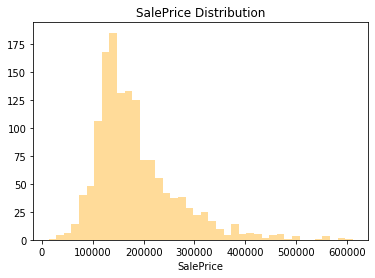

In [15]:
#Check distribution of our target
sns.distplot(y_train, kde=False, color='orange');
plt.title('SalePrice Distribution');

In [16]:
#Check skew of target
y_train.skew()

1.5585076163455256

As you can see from the above plot, we do indeed see a strong positive/right skew for our target. The .skew() method confirms this-- this method returns an unbiased, normalized skew for our target. This is a measure of asymmetry that we'll leverage to isolate features for transformation as well. From the below you can see that we are picking up Ordinal features, as well as SF/Area features.

In [17]:
#Let's look at some of the top skewed features
X_train.skew().sort_values(ascending=False).head(10)

Neighborhood_StoneBr    7.539519
Bldg Type_2fmCon        7.085079
Neighborhood_Timber     6.583208
Lot Area                6.457309
Neighborhood_NoRidge    6.366526
Neighborhood_IDOTRR     5.251762
Bldg Type_Twnhs         5.074451
Bldg Type_Duplex        5.018731
Neighborhood_BrkSide    4.810706
Kitchen AbvGr           4.660424
dtype: float64

In preparation for our transformations, we need to make one tweak to our data. It's impossible to take the log of zero, and many of our features have values 0 (in particular, dummy features). To account for this, we will add 1 to our features. This allows us to make the transformation, but does not alter the relationship within and among features as it's applied uniformly.

In [18]:
X_test_alt =X_test_alt.dropna()

In [19]:
#Adjust our feature set values to enable log transformation.
X_train = X_train + 1
X_test = X_test + 1
X_test_alt = X_test_alt +1

In [20]:
#Do to the same for our target
y_train = np.log(y_train)

Now we'll select what features should be transformed. This was another level that we decided to pull when generating our models. Because 0 is representative of a normal distribution, we tested transforming features with skew between 0 and 1.7 (our target). What we determined is that cutting off our list as skew = 0.8 was reasonable and had the intended positive impact desired on R2 results. So, we will go ahead and make that cutoff below. We'll then isolate and transform those features across our train, test, and submission data sets.

In [21]:
#Isolate the features that we'll be transforming
X_to_transform = list(X_train.skew().sort_values(ascending=False).head(15).index)

#Apply transformations to isolate features across our datasets
X_train[X_to_transform] = np.log(X_train[X_to_transform])
X_test[X_to_transform] = np.log(X_test[X_to_transform])
X_test_alt[X_to_transform] = np.log(X_test_alt[X_to_transform])

#### Scaling

For our last transformation, we'll scale our data. While this isn't completely necessary for the execution of multivariate linear regression, this step is needed for more advanced regularization methods which we will apply later (**Ridge, Lasso, ElasticNet**). One thing to make note of with scaling is the issue of interpretability -- coefficients in a standard linear regression model are simple to explain, however scaling adds a layer of abstraction. This will make interpretation that much more difficult for some of the more advanced mechanisms we'll employ to optimize our model.

That being said, scaling is needed here, because we'll be penalizing coefficients based on magnitude of the coefficients to prevent **overfitting** of our model. The size of that coefficient depends on the scale of our feature.

In [22]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
X_test_alt_sc = ss.transform(X_test_alt)

### Modeling

After all the steps that have been taken so far, we are now ready to move forward with model building and validation. The general process is iterative but can be broken down into the follow steps:

 - Model Instiation
 - Model Fitting
 - Model Predicting
 - Model Validation

Throughout the process, we'll want to take a look at the following areas to ensure that our model is performing well:
 - **Residual Plots**: Linear Regression models have several baseline assumptions in place, and these plots will help us to evaluate. First is the notion that our residuals are normally distributed. The second is that our residuals demonstrate homoscedasticity-- that is, they demonstrate randomnes as our independent variables change in value. 
 - **R2 Score** -- this metric is key for our iterative approach to modeling. It tells us the percent of variance that is explained by our model. We're looking for a high R2 score (as close to 1 as possible). In addition to a high R2, we're also looking for consistency in R2 scores across our training set and test sets. If we can push R2 up on our test set (data that our model has not seen), this means our model will demonstrating lower variance.
 - **RMSE**: This is the error metric our Kaggle competition is based on. For the purposes of this notebook we are not explicitly evaluating this metric. However, upon submission we will be tracking our RMSE outcomes.

#### Instantiation

Start by instantiation our models. We mentioned that we'll be using a few different regularization methods for our model, you can see below that these are being included. A brief overview of these approaches may be helpful for the remainder of this notebook:

 - **Ridge Regression**: Ridge introduces a new parameter, alpha, into the traditional linear regression formula. The aplha parameter penalizes coefficients that become too large in our model. It does this because large coefficients can lead to larger squared errors. 
 - **Lasso Regression**: Lasso is similar to Ridge in that it can result in the reduction of coefficients for our linear regression model. A key difference here, though, is that Lasso can fully eliminate features, making it a great choice for feature selection.
 - **ElasticNet**: This is a hybrid of Ridge and Lasso. ElasticNet includes a parameter (L1 Ratio) which will allow us to tweak which features of Ridge, and which features of Lasso, are predominant in our final model. 

In [23]:
lr= LinearRegression()
lasso = LassoCV(n_alphas=1000, cv=3)
ridge = RidgeCV(alphas=np.linspace(.1, 40, 100))
elastic = ElasticNetCV(cv=5, random_state=42)

####  Cross Val Score 

With our models instantiated, we can now move forward with **k-fold validation**. This is a statistical approach to model evaluation which allows us to sample from different chunks of our dataset to reduce bias introduced by any one chunk. For each chunk of data, we will train our model on it, and assess R2. By taking the mean across the number of folds we assess, we can get a better sense of anticipated performance of our model. For this section, we will take 3 folds of our training data and assess the mean R2.

Linear Regression

In [24]:
X_train.shape

(1433, 94)

In [25]:
#Use k-fold validation across our models
lr_scores = cross_val_score(lr, X_train, y_train, cv=3)
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=3);
ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=3)
elastic_scores = cross_val_score(elastic, X_train_sc, y_train, cv=3)

#print mean of our kfold model results (R2)
print(lr_scores.mean(),lasso_scores.mean(),ridge_scores.mean(),elastic_scores.mean())

0.900115949153287 0.9027335942462221 0.9020356990844799 0.9029651979806895


From the above, we can see that our R2 scores rank our models from worst to best in the following order: Linear (normal), Ridge, ElasticNet, Lasso. Based on these results, up to **90% of the variance** in the data can be explained by our model for our training data-- this is a strong result.

Because ElasticNet is a combination of both Ridge and Lasso, it's reasonable to see it's performance inbetween these two models. Let's move forward with all of these models and now assess it's performance against our test data.

####  Linear Regression Predictions

Let's begin by using our linear regression model to predict SalePrice. We'll do this by leveraging the **.predict()** method and our **X_test** data. As a reminder, our model has yet to see X_test, so this is an important step in understanding the tradeoff our model is exhibiting between bias and variance.

In [26]:
#fit our model with training data
lr.fit(X_train, y_train);

In [27]:
#generate our predictions
submission_predictions = lr.predict(X_test)

In [28]:
#undo the log transformation we applied previously
submission_predictions =  np.exp(submission_predictions)

In [29]:
#score the holdout SalePrice data against our prediction
submission_predictions_lr_r2 = r2_score(y_test, submission_predictions)
submission_predictions_lr_r2

0.9346260245600196

We've seen an improvement in our R2 scored to 0.92 with our test data which demonstrates our model is actually more accurate with this particular cut of unseen data, when compared to our k-fold asessement of training data. This means that our model is showing low variance. Now, we want to take a look at our resultant residuals. As a reminder, we are looking for consistent randomness in our variance -- when plotted against our SalePrice values, we don't want to see any visual patterns. Similarly, when plotted alone, our residuals should resemble a cloud with no real pattern.

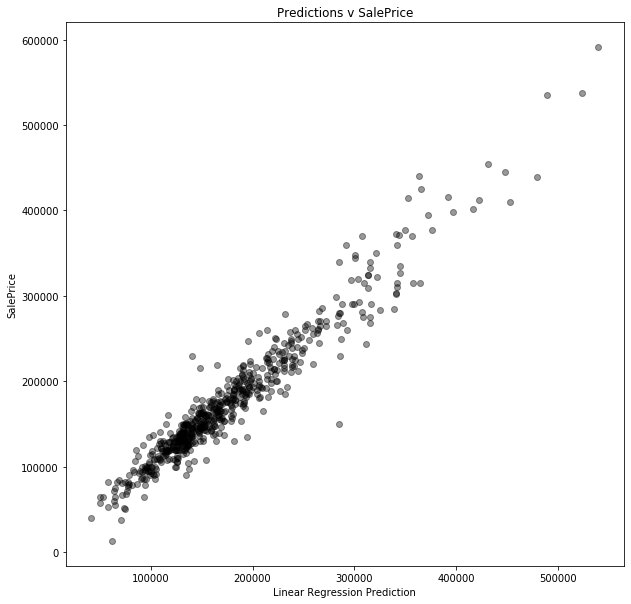

In [30]:
#Generate a figure ouf our residuals for LinearReg Model
plt.figure(figsize=(10,10))
residuals = y_test - submission_predictions
plt.scatter(submission_predictions, y_test, color='black', alpha=0.4);
plt.title('Predictions v SalePrice');
plt.xlabel('Linear Regression Prediction');
plt.ylabel('SalePrice');

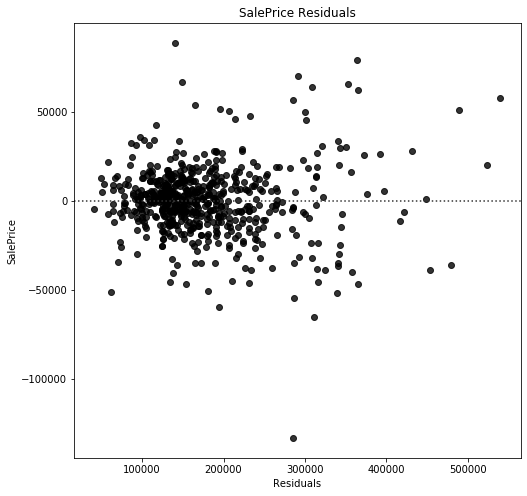

In [31]:
plt.figure(figsize=(8,8))
residuals_test = y_test - submission_predictions
sns.residplot(submission_predictions, y_test, color='black');
plt.title('SalePrice Residuals');
plt.xlabel('Residuals');

In [32]:
residuals_test.sort_values(ascending=True)

125    -134781.490176
378     -67591.364974
9       -59726.371364
1612    -56210.313703
186     -54204.100738
            ...      
1897     62576.653680
1458     67216.572763
498      68030.870071
1503     76150.957151
1211     89293.433625
Name: SalePrice, Length: 615, dtype: float64

Looking at the first graph, we do see general consistency with our residual plot. However, our residuals begin to fan out as our SalePrice increases, indicated levels of heteroskedasicity. While it's difficult to fully avoid this in our residuals, this is something to take note off -- you can see visually that at higher prices residuals begin to fan. In the second plot, you can see that our residuals are pretty well distributed. 

This is our current best performing model. Let's now predict with Lasso, Ridge, and ElasticNet to see if we can generate a stronger R2 value.

####  Lasso Regression Model  Evaluation

In [33]:
#Fit our lasso model and predict on the test data set
y_train_lasso = y_train.copy()
lasso.fit(X_train_sc, y_train_lasso);
submission_predictions_lasso = lasso.predict(X_test_sc)

In [34]:
#submission_predictions_lasso = submission_predictions_lasso.reshape(-1,1)
submission_predictions_lasso =  np.exp(submission_predictions_lasso)
submission_predictions__lasso_r2 = r2_score(y_test, submission_predictions_lasso)
submission_predictions__lasso_r2

0.9340674313579135

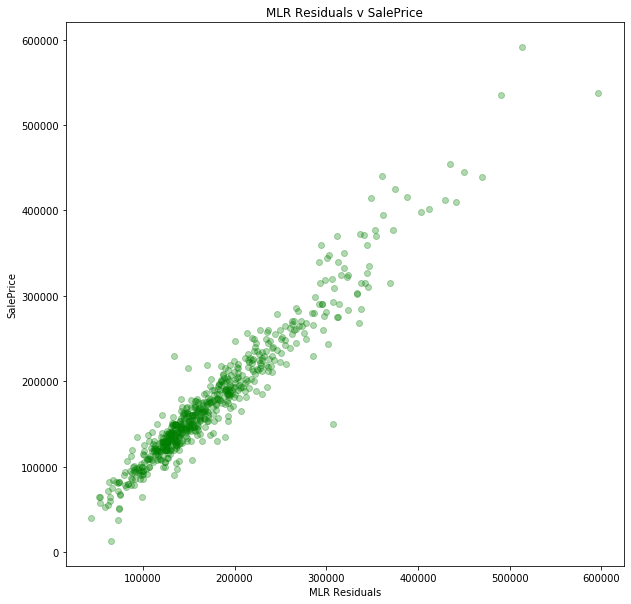

In [35]:
#Plot Lasso Residuals
plt.figure(figsize=(10,10))
residuals_elastic = y_test - submission_predictions_lasso
plt.scatter(submission_predictions_lasso, y_test, color='green', alpha=0.3);
plt.title('MLR Residuals v SalePrice');
plt.xlabel('MLR Residuals');
plt.ylabel('SalePrice');

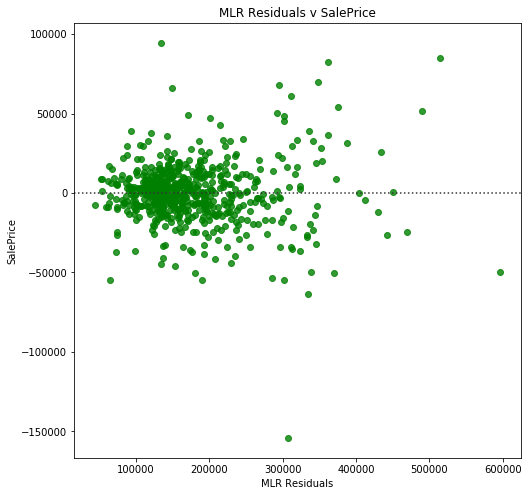

In [36]:
plt.figure(figsize=(8,8))
residuals_elastic = y_test - submission_predictions_lasso
sns.residplot(submission_predictions_lasso, y_test, color='green');
plt.title('MLR Residuals v SalePrice');
plt.xlabel('MLR Residuals');


####  Ridge Regression Model Evaluation

In [37]:
#Fit our ridge model and predict on the test data set
ridge.fit(X_train_sc, y_train);
submission_predictions_ridge = ridge.predict(X_test_sc)
submission_predictions_ridge =  np.exp(submission_predictions_ridge)

In [38]:
submission_predictions_ridge_r2 = r2_score(y_test, submission_predictions_ridge)
submission_predictions_ridge_r2

0.9340968878661529


####  Elastic Model Evaluation

In [39]:
#Fit our ElasticNet model and predict on the test data set
elastic.fit(X_train_sc, y_train);
submission_predictions_elastic = elastic.predict(X_test_sc)
submission_predictions_elastic =  np.exp(submission_predictions_elastic)

In [40]:
submission_predictions_ridge_elastic_r2 = r2_score(y_test, submission_predictions_elastic)
submission_predictions_ridge_elastic_r2

0.9344958716511914

We see improvement from our R2 of **0.931** with our standard Linear Regression model to **0.937** with our Lasso model. We see only very marginal gains in R2 between our Lasso and Elastic test results which makes sense -- Lasso contributes to the ElasticNet model. 


####  Refitting our data to the FULL Training data

The goal of train_test_split() is to holdout a subset of data that we can test against to ensure that our model is generalizeable. Now that we've determined the R2 score for our test set to be marginally better than our training set, we will now take our final model and fit it against the full training set. This should help us make our model even more generalizeable.

In [41]:
#Scale our full training data set
X_train_all_sc = ss.fit_transform(X_train_alt)

y_train_all = np.log(y_train_data)

#Instantiate our models and label them in reference to the full data set
lr_alltraining= LinearRegression()
lasso_alltraining = LassoCV(n_alphas=1000, cv=5)
ridge_alltraining = RidgeCV(alphas=np.linspace(.1, 40, 100), cv=5)
elastic_alltraining = ElasticNetCV(cv=5, random_state=42)

#Fit our models against the full training set
lr_alltraining.fit(X_train_all_sc,y_train_all);
lasso_alltraining.fit(X_train_all_sc,y_train_all);
ridge_alltraining.fit(X_train_all_sc,y_train_all);
elastic_alltraining.fit(X_train_all_sc,y_train_all);

In [42]:
#Cross validate all models against our full training data set 
lr_all_scores = cross_val_score(lr_alltraining, X_train_all_sc, y_train_all, cv=3);
lasso__allscores = cross_val_score(lasso_alltraining, X_train_all_sc, y_train_all, cv=3);
ridge_all_scores = cross_val_score(ridge_alltraining, X_train_all_sc, y_train_all, cv=3);
elastic_all_scores = cross_val_score(elastic_alltraining, X_train_all_sc, y_train_all, cv=3);

#Print out all the scores so far
print('original training data R2:')
print(lr_scores.mean(),lasso_scores.mean(),ridge_scores.mean(), elastic_scores.mean())

print('test scores:')
print(submission_predictions_lr_r2, submission_predictions__lasso_r2, submission_predictions_ridge_r2, submission_predictions_ridge_elastic_r2)

print('all training data R2:')
print(lr_all_scores.mean(), lasso__allscores.mean(), ridge_all_scores.mean(), elastic_all_scores.mean())

original training data R2:
0.900115949153287 0.9027335942462221 0.9020356990844799 0.9029651979806895
test scores:
0.9346260245600196 0.9340674313579135 0.9340968878661529 0.9344958716511914
all training data R2:
0.9027450783226606 0.901396475131353 0.9023524735388505 0.9014518533768463


In [43]:
lr_scores,lasso_scores,ridge_scores, elastic_scores

(array([0.89513855, 0.91440122, 0.89080808]),
 array([0.89278496, 0.91982474, 0.89559108]),
 array([0.89518428, 0.91915658, 0.89176623]),
 array([0.89326105, 0.91995359, 0.89568095]))

In [44]:
lr_all_scores, lasso__allscores, ridge_all_scores, elastic_all_scores

(array([0.89599525, 0.90705045, 0.90518954]),
 array([0.89464636, 0.9044144 , 0.90512867]),
 array([0.89486819, 0.90754666, 0.90464257]),
 array([0.89462679, 0.90463823, 0.90509054]))

In [45]:
from sklearn.metrics import mean_squared_error

print("RMSE: Linear Subset Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(lr.predict(X_test_sc)))))
print("RMSE: Lasso Subset Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(lasso.predict(X_test_sc)))))
print("RMSE: Ridge Subset Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(ridge.predict(X_test_sc)))))
print("RMSE: Elastic Subset Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(elastic.predict(X_test_sc)))))



RMSE: Linear Subset Training Data
192479.06946602062
RMSE: Lasso Subset Training Data
19679.27223782202
RMSE: Ridge Subset Training Data
19674.875720159947
RMSE: Elastic Subset Training Data
19615.228509810833


In [46]:
from sklearn.metrics import mean_squared_error

print("RMSE: Linear All Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(lr_alltraining.predict(X_test_sc)))))
print("RMSE: Lasso All Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(lasso_alltraining.predict(X_test_sc)))))
print("RMSE: Ridge All Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(ridge_alltraining.predict(X_test_sc)))))
print("RMSE: Elastic All Training Data")
print(np.sqrt(mean_squared_error(y_test, np.exp(elastic_alltraining.predict(X_test_sc)))))



RMSE: Linear All Training Data
19355.7808447773
RMSE: Lasso All Training Data
19427.197610126503
RMSE: Ridge All Training Data
19209.88719380212
RMSE: Elastic All Training Data
19400.235039789688


Let's take a look at the coefficients that we generated with our lasso model. These coefficients make a lot of sense -- general living area, overall quality, basement square footage, etc. -- these are all features that would certainly be listed on a Zillow ad for a home.

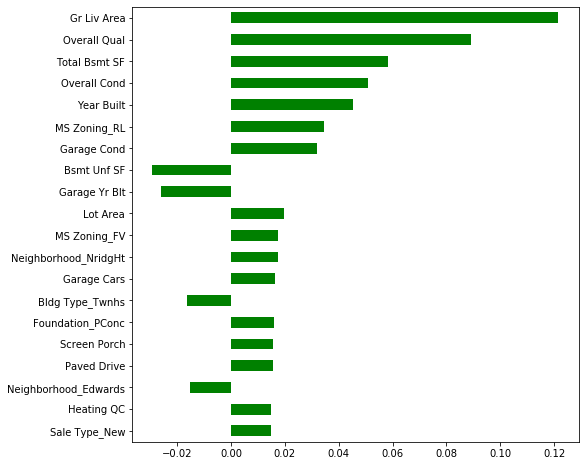

In [59]:
plt.figure(figsize=(8,8))
ax = coef_table.sort_values('Magnitude',ascending=False).head(20)['Coefficients'].plot(kind='barh', color='green')
ax.invert_yaxis()

####  Submission

In [47]:
# #Build predictions with these new models
submit_predictions_ridge_all = np.exp(ridge_alltraining.predict(X_test_alt_sc))

In [49]:
# #Build predictions with these new models
submit_predictions_lasso_all = np.exp(lasso_alltraining.predict(X_test_alt_sc))

In [50]:
submit_predictions_lasso_all.mean()

175911.51604705694

Finally, we are ready to submit our predictions. We'll read out our file to the data folder for Kaggle submission.

In [53]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(lasso_alltraining.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(20)['Coefficients']

Gr Liv Area             0.121555
Overall Qual            0.089236
Total Bsmt SF           0.058459
Overall Cond            0.050843
Year Built              0.045166
MS Zoning_RL            0.034658
Garage Cond             0.031940
Bsmt Unf SF            -0.029192
Garage Yr Blt          -0.026078
Lot Area                0.019802
MS Zoning_FV            0.017540
Neighborhood_NridgHt    0.017457
Garage Cars             0.016407
Bldg Type_Twnhs        -0.016397
Foundation_PConc        0.016009
Screen Porch            0.015619
Paved Drive             0.015489
Neighborhood_Edwards   -0.015278
Heating QC              0.014876
Sale Type_New           0.014754
Name: Coefficients, dtype: float64

In [ ]:
submission = pd.DataFrame(submission_ids)
submission['SalePrice'] = submit_predictions_lasso_all

In [ ]:
submission['Id'] = submission['Id'].astype('int')
submission.dtypes, submission.shape

In [ ]:
submission.to_csv('./datasets/sample_sub_reg.csv', index=False)

### Additional Diagnostic Analysis

In [52]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(lasso.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(10)['Coefficients']

Gr Liv Area      0.112516
Overall Qual     0.086928
Total Bsmt SF    0.054228
Overall Cond     0.046246
Lot Area         0.043407
MS Zoning_RL     0.041193
Year Built       0.040927
MS Zoning_RM     0.032944
Bsmt Unf SF     -0.026309
MS Zoning_FV     0.025712
Name: Coefficients, dtype: float64

In [ ]:
coef_diff_table = pd.DataFrame(lr.coef_ - lr_alltraining.coef_,index=X_train.columns, columns=['diff'])

In [ ]:
coef_diff_table.sort_values(by ='diff',ascending=False).head(10)